# Predição de Despesas Médicas <br/>do Seguro de Saúde

Paulo Cysne Rios Jr. | Novembro 2017

## Solução do Aluno: Cleiton Lima Rocha

## Exercício

Este conjunto de dados *insurance.csv* representa despesas médicas de indivíduos nos EUA.<br/>
O valor objetivo é as despesas (expenses).  <br/>
Predizer despesas médicas é de fundamental importância para uma empresa de seguros de saúde. É tambem de interesse de cada pessoa.

- Encontre as despesas por região
- Usando regressão linear múltipla, vom a classe LinearRegression, prediza as despesas <br/>
e veja como se saiu usando MSE. 
- Melhore sua modelagem: use um indicador para BMI acima ou igual a 30<br/>
e veja como se saiu usando MSE. 
- Melhore sua modelagem: use regressão polinomial e veja como se saiu usando MSE. 
- Usando a classe SGDRegressor (de Descida de Gradiente Estocástico), <br/>
prediza as despesas (expenses) para os casos acima e veja como se saiu usando MSE. 
- Faça uma tabela com todas as MSE e encontre a melhor.
- Lembre-se de calcular o MSE usando a package metrics de SciKit-Learn.
- Os primeiros passos da modelagem estão abaixo.

In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
train = pd.read_csv('data/insurance.csv')

In [207]:
train.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# Verificar valores nulos

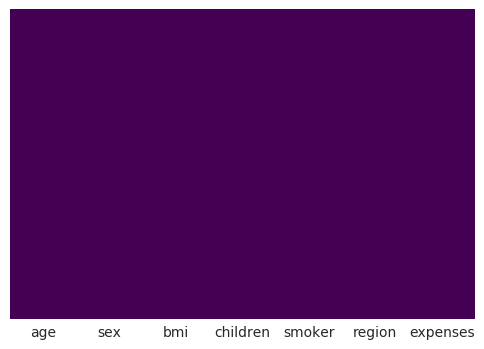

In [208]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Plots (insight)

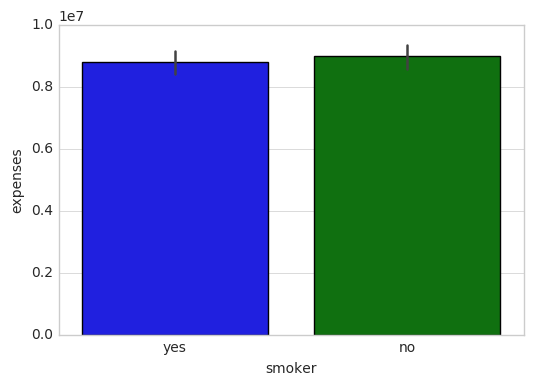

In [209]:
#Fumantes vs total
sns.set_style('whitegrid')
sns.barplot(x="smoker", y="expenses", data=train, estimator=sum)

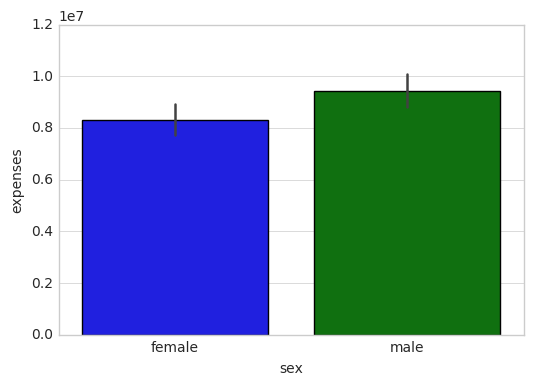

In [210]:
#Sex vs Total
sns.barplot(x="sex", y="expenses", data=train, estimator=sum)

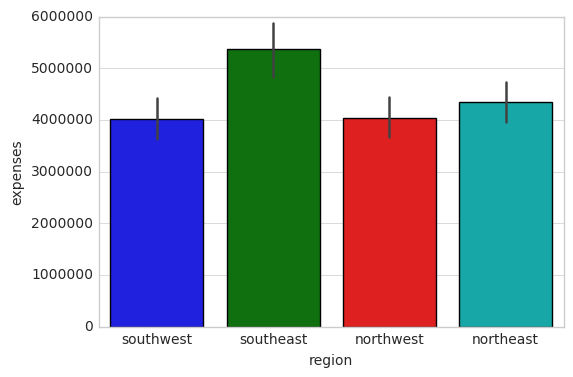

In [211]:
#Region vs Total
sns.barplot(x="region", y="expenses", data=train, estimator=sum)

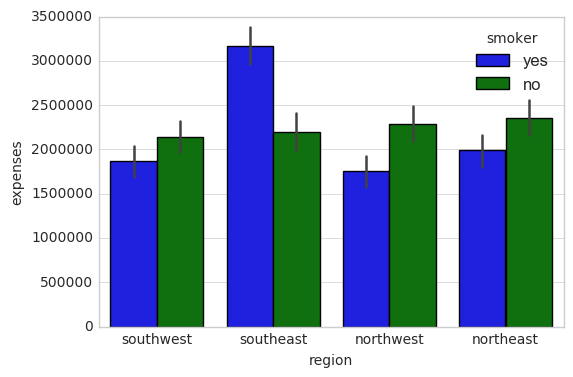

In [212]:
#Region vs Total
sns.barplot(x="region", y="expenses", hue="smoker", data=train, estimator=sum)

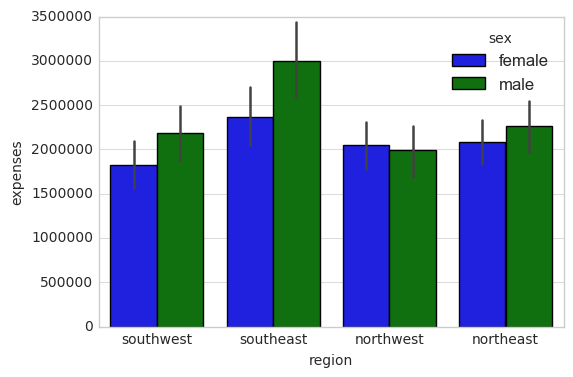

In [213]:
#Region, sex vs Total
sns.barplot(x="region", y="expenses", hue="sex", data=train, estimator=sum)

# Aplicando o Pré-processamento

In [214]:
#Aplicando a ordem na idade
def impute_age_band(cols):
    age = cols[0]
    if age > 0 and age <= 18:
        return 1
    elif age > 18 and age <= 23:
        return 2
    elif age > 23 and age <= 28:
        return 3
    elif age > 28 and age <= 33:
        return 4
    elif age > 33 and age <= 38:
        return 5
    elif age > 38 and age <= 43:
        return 6
    elif age > 44 and age <= 48:
        return 7
    elif age > 48 and age <= 53:
        return 8
    elif age > 53 and age <= 58:
        return 9
    else:
        return 10

In [215]:
#Inserindo as faixas de idade
ages_band = train[['age']].apply(impute_age_band,axis=1)
train.insert(0, 'age_band', ages_band)
train.drop(['age'],axis=1,inplace=True)
train.head()

,age_band,sex,bmi,children,smoker,region,expenses
0,2,female,27.9,0,yes,southwest,16884.92
1,1,male,33.8,1,no,southeast,1725.55
2,3,male,33.0,3,no,southeast,4449.46
3,4,male,22.7,0,no,northwest,21984.47
4,4,male,28.9,0,no,northwest,3866.86


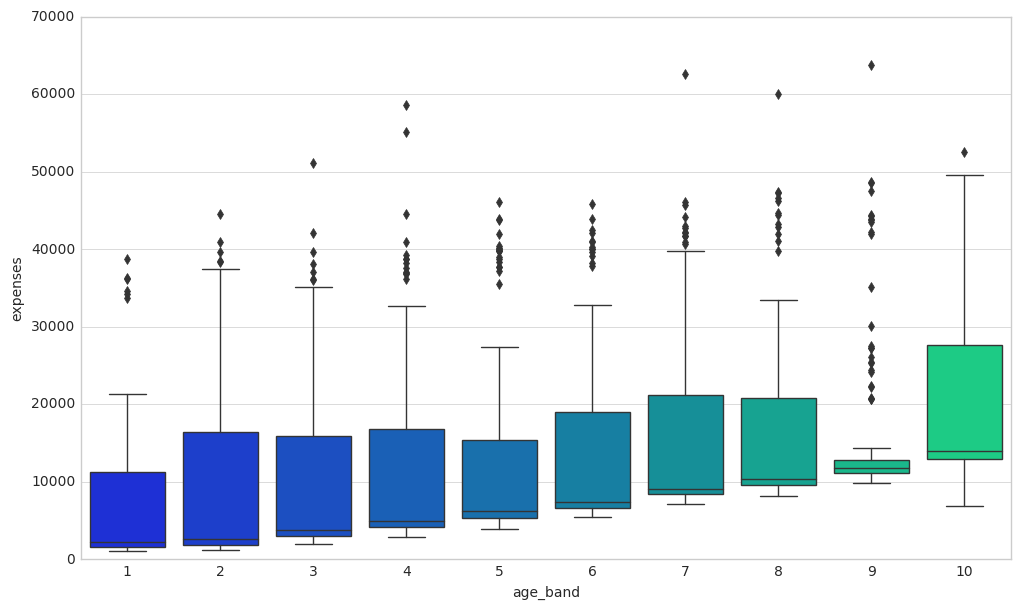

In [216]:
#Visualizando os outliers
plt.figure(figsize=(12, 7))
sns.boxplot(x='age_band',y='expenses',data=train,palette='winter')

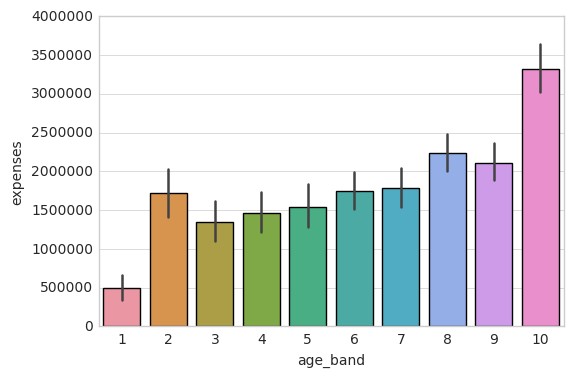

In [217]:
#Region vs Total
sns.barplot(x="age_band", y="expenses", data=train, estimator=sum)

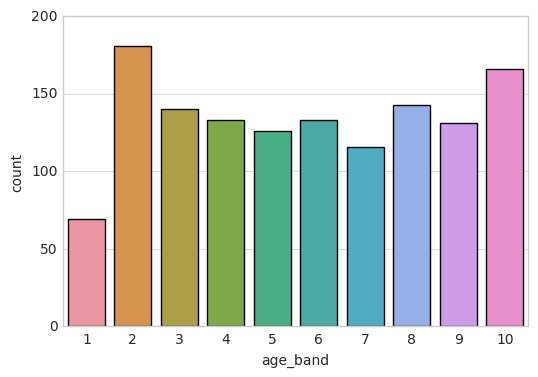

In [218]:
#Region vs Total
sns.countplot(x="age_band", data=train)

In [219]:
#Hot Enconding de Smokers, Sex e Region
sex = pd.get_dummies(train['sex'],drop_first=True)
smokers = pd.get_dummies(train['smoker'],drop_first=True)
regions = pd.get_dummies(train['region'],drop_first=True)
train.drop(['sex','smoker','region'],axis=1,inplace=True)
train = pd.concat([train,smokers,regions,sex],axis=1)
train.head()

,age_band,bmi,children,expenses,yes,northwest,southeast,southwest,male
0,2,27.9,0,16884.92,1.0,0.0,0.0,1.0,0.0
1,1,33.8,1,1725.55,0.0,0.0,1.0,0.0,1.0
2,3,33.0,3,4449.46,0.0,0.0,1.0,0.0,1.0
3,4,22.7,0,21984.47,0.0,1.0,0.0,0.0,1.0
4,4,28.9,0,3866.86,0.0,1.0,0.0,0.0,1.0


In [220]:
#Aplicando o BMI > 30
#Inserindo as faixas de idade
train['bmi'] = train['bmi'].apply(lambda x: 1 if x >= 30 else 0)
train.head()

,age_band,bmi,children,expenses,yes,northwest,southeast,southwest,male
0,2,0,0,16884.92,1.0,0.0,0.0,1.0,0.0
1,1,1,1,1725.55,0.0,0.0,1.0,0.0,1.0
2,3,1,3,4449.46,0.0,0.0,1.0,0.0,1.0
3,4,0,0,21984.47,0.0,1.0,0.0,0.0,1.0
4,4,0,0,3866.86,0.0,1.0,0.0,0.0,1.0


# Construindo o modelo - Linear Regression
<!-- 
#Aplicando normalização sobre age_band e children
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train['age_band'] = scaler.fit_transform(train['age_band'].reshape(-1, 1))
train['children'] = scaler.fit_transform(train['children'].reshape(-1, 1))
train.head()
-->

In [221]:
Y = train['expenses'] #VD
X = train.drop('expenses', axis=1)#VI

In [222]:
#Separando o Train vs Test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [223]:
#Treinando o modelo Linear Regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [224]:
#Aplicanodo a predição sobre o teste
predictions = lm.predict(X_test)

In [225]:
#Calculando o MSE
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_test, predictions))
print('MSE:', metrics.mean_squared_error(Y_test, predictions))

MAE: 4316.04241015
MSE: 35474653.1229


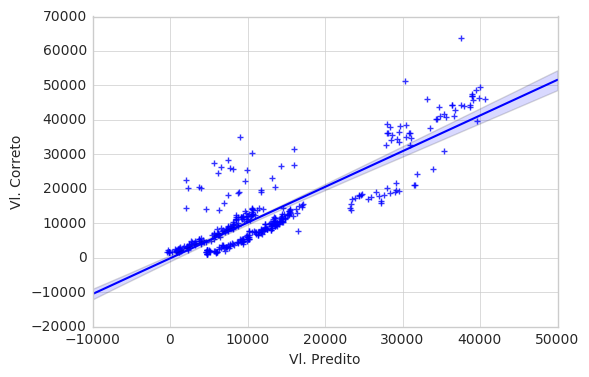

In [226]:
x, y = pd.Series(predictions, name="Vl. Predito"), pd.Series(Y_test, name="Vl. Correto")
ax = sns.regplot(x=x, y=y, marker="+")

# Construindo o modelo - SGDRegressor

In [227]:
from sklearn.linear_model import SGDRegressor 
sgdr = SGDRegressor(max_iter=1000, eta0=0.01)
sgdr.fit(X_train, Y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [228]:
#Aplicanodo a predição sobre o teste
predictionsSGDR = sgdr.predict(X_test)

In [229]:
#Calculando o MSE
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_test, predictionsSGDR))
print('MSE:', metrics.mean_squared_error(Y_test, predictionsSGDR))

MAE: 4329.49863576
MSE: 35291350.373


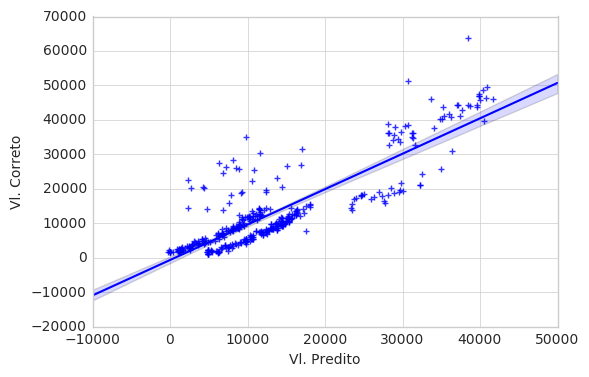

In [230]:
x, y = pd.Series(predictionsSGDR, name="Vl. Predito"), pd.Series(Y_test, name="Vl. Correto")
ax1 = sns.regplot(x=x, y=y, marker="+")